## Download SOX404 inernal control set from Audit Analytics data from WRDS

-------------------------

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wrds
pd.options.display.max_columns=200

-------------

### Connect WRDS

In [2]:
conn=wrds.Connection()

Enter your WRDS username [yjaey]: yjaeyoon
Enter your password: ···············


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
Loading library list...
Done


### Get variable list

In [3]:
sox404_vars= conn.describe_table(library='audit', table='auditsox404')['name']
print(len(sox404_vars))

Approximately 196431 rows in audit.auditsox404.
243


In [4]:
vars_to_skip= ['matchfy', 'matchqu', 'closestfy', 'closestqu', 'priorqu', 'priorfy', 'note', 'opinion_text', 'eventdate']
for idx, var in enumerate(sox404_vars):
    if any(var_to_skip in var for var_to_skip in vars_to_skip):
        pass
    else:        
        print(idx, var)

0 is_nth_restate
1 ic_op_fkey
2 ic_op_type
3 auditor_fkey
4 auditor_agrees
5 combined_ic_op
6 ic_is_effective
7 fye_ic_op
8 sig_date_ic_op_x
9 sig_date_ic_op_s
10 aud_city
11 aud_state
12 aud_state_name
13 aud_state_reg
14 count_weak
15 op_aud_name
16 op_aud_pcaob
17 audit_fees
18 non_audit_fees
19 benefits_fees
20 it_fees
21 tax_fees
22 audit_related_fees
23 other_fees
24 total_fees
25 currency_code_fkey
26 restatement
30 exemption
31 exe_reas_keys
32 exe_reas_phr
42 fy_ic_op
43 ftp_file_fkey
44 form_fkey
45 file_date
46 file_accepted
47 file_size
48 http_name_html
49 http_name_text
50 company_fkey
51 best_edgar_ticker
196 ic_text1
197 ic_text2


### Select variables to download

In [5]:
vars_to_keep= ['is_nth_restate', 'ic_op_fkey', 'ic_op_type', 'auditor_fkey', 'combined_ic_op', 'fye_ic_op', 
               'count_weak', 'audit_fees', 'non_audit_fees', 'fy_ic_op', 'company_fkey', 'exe_reas_keys', 'exe_reas_phr']

### Pilot check

In [6]:
df_test= conn.get_table(library= 'audit', table='auditsox404',
                       columns= vars_to_keep,
                       obs= 3)
df_test

,is_nth_restate,ic_op_fkey,ic_op_type,auditor_fkey,combined_ic_op,fye_ic_op,count_weak,audit_fees,non_audit_fees,fy_ic_op,company_fkey,exe_reas_keys,exe_reas_phr
0,0.0,19322.0,a,6.0,0.0,2006-12-30,0.0,574000.0,7000.0,2006.0,0000000020,|1|,|Ex - Acquisition(s) during the past year (exe...
1,0.0,19323.0,m,6.0,0.0,2006-12-30,0.0,574000.0,7000.0,2006.0,0000000020,|1|,|Ex - Acquisition(s) during the past year (exe...
2,0.0,29581.0,m,6.0,0.0,2007-12-29,0.0,669000.0,2000.0,2007.0,0000000020,|1|,|Ex - Acquisition(s) during the past year (exe...


In [7]:
df= conn.get_table(library= 'audit', table='auditsox404',
                       columns= vars_to_keep)
df.head()

,is_nth_restate,ic_op_fkey,ic_op_type,auditor_fkey,combined_ic_op,fye_ic_op,count_weak,audit_fees,non_audit_fees,fy_ic_op,company_fkey,exe_reas_keys,exe_reas_phr
0,0.0,19322.0,a,6.0,0.0,2006-12-30,0.0,574000.0,7000.0,2006.0,0000000020,|1|,|Ex - Acquisition(s) during the past year (exe...
1,0.0,19323.0,m,6.0,0.0,2006-12-30,0.0,574000.0,7000.0,2006.0,0000000020,|1|,|Ex - Acquisition(s) during the past year (exe...
2,0.0,29581.0,m,6.0,0.0,2007-12-29,0.0,669000.0,2000.0,2007.0,0000000020,|1|,|Ex - Acquisition(s) during the past year (exe...
3,0.0,29580.0,a,6.0,0.0,2007-12-29,0.0,669000.0,2000.0,2007.0,0000000020,|1|,|Ex - Acquisition(s) during the past year (exe...
4,0.0,28885.0,m,1687.0,0.0,2007-12-31,0.0,1235999.0,417735.0,2007.0,0000003982,None,None


In [8]:
df.is_nth_restate.value_counts()

0.0    192272
1.0      3894
2.0       197
3.0        35
4.0        18
5.0        15
Name: is_nth_restate, dtype: int64

In [9]:
df= df[df.is_nth_restate==0].drop(columns= 'is_nth_restate')

In [10]:
df.rename(columns={'ic_op_fkey':'ic_key',
                  'auditor_fkey':'afk',
                  'combined_ic_op':'combined',
                  'ic_is_effective':'ic_eff',
                  'fye_ic_op':'fyear_end',
                  'count_weak':'n_weak',
                  'audit_fees':'afees',
                  'non_audit_fees':'nafees',
                  'fy_ic_op':'fy',
                  'company_fkey':'cik'},
         inplace=True)

In [11]:
df.head(2)

,ic_key,ic_op_type,afk,combined,fyear_end,n_weak,afees,nafees,fy,cik,exe_reas_keys,exe_reas_phr
0,19322.0,a,6.0,0.0,2006-12-30,0.0,574000.0,7000.0,2006.0,0000000020,|1|,|Ex - Acquisition(s) during the past year (exe...
1,19323.0,m,6.0,0.0,2006-12-30,0.0,574000.0,7000.0,2006.0,0000000020,|1|,|Ex - Acquisition(s) during the past year (exe...


In [12]:
vars_to_int= ['ic_key', 'combined', 'n_weak', 'afees', 'nafees']
df[vars_to_int]=df[vars_to_int].astype(int)

# fy should be switched to float and then int.
df.fy= df.fy.astype('float').astype('int')

df['weak_exist']= (df['n_weak']>0).astype(int)

# ic_op_type: m/a to manager/auditor
df['ic_op_type']= df['ic_op_type'].map(dict(m='manager', a='auditor'))

df.head(2)

,ic_key,ic_op_type,afk,combined,fyear_end,n_weak,afees,nafees,fy,cik,exe_reas_keys,exe_reas_phr,weak_exist
0,19322,auditor,6.0,0,2006-12-30,0,574000,7000,2006,0000000020,|1|,|Ex - Acquisition(s) during the past year (exe...,0
1,19323,manager,6.0,0,2006-12-30,0,574000,7000,2006,0000000020,|1|,|Ex - Acquisition(s) during the past year (exe...,0


In [13]:
df.sort_values('fy', inplace= True)

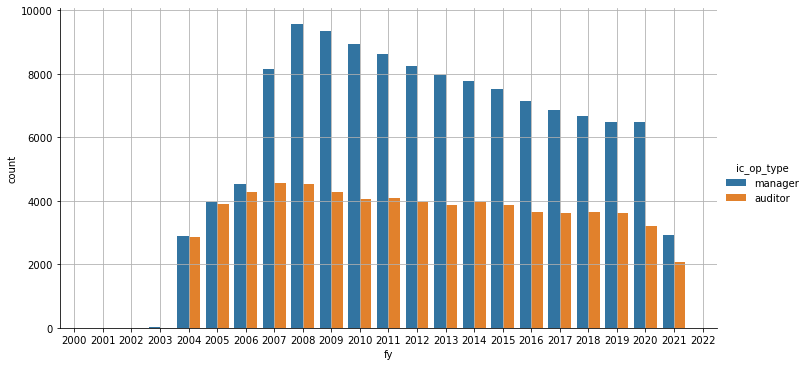

In [14]:
ax= sns.catplot(data= df, x="fy", kind="count", height=5, aspect=2, hue= 'ic_op_type')
plt.grid()
plt.show()

In [15]:
df=df[(df.fy>=2004) & (df.fy<=2020)]
df_404a= df[df.ic_op_type=='manager'].drop(columns='ic_op_type')
df_404b= df[df.ic_op_type=='auditor'].drop(columns='ic_op_type')

---------------------

## Check data with visualization

### Proportion of firms with internal control weaknesses under 404a and 404b

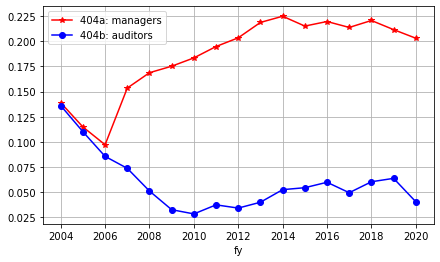

In [16]:
df_404a.groupby(['fy']).mean()['weak_exist'].plot(kind='line', figsize=(7,4), grid= True, color= 'r', marker="*", label= '404a: managers')
df_404b.groupby(['fy']).mean()['weak_exist'].plot(kind='line', figsize=(7,4), grid= True, color= 'b', marker="o", label= '404b: auditors')
plt.legend()
plt.show()

### The number of firms with internal control weaknesses under 404a and 404b

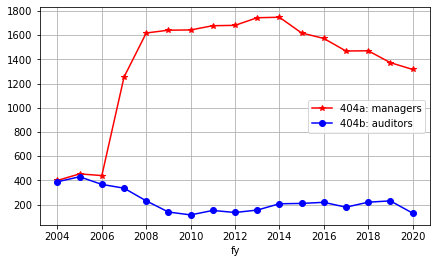

In [17]:
df_404a.groupby(['fy']).sum()['weak_exist'].plot(kind='line', figsize=(7,4), grid= True, color= 'r', marker="*", label= '404a: managers')
df_404b.groupby(['fy']).sum()['weak_exist'].plot(kind='line', figsize=(7,4), grid= True, color= 'b', marker="o", label= '404b: auditors')
plt.legend()
plt.show()

---------

<b>Note that NAFs became subject to 404a since 2007. The graphs should be interpreted very carefully.</b>

--------------------

### Save data

In [18]:
df_404a.to_csv('data/404a.csv', index= False)
df_404b.to_csv('data/404b.csv', index= False)
df_404b.head()

,ic_key,afk,combined,fyear_end,n_weak,afees,nafees,fy,cik,exe_reas_keys,exe_reas_phr,weak_exist
104328,743,2.0,0,2004-12-31,0,971000,296000,2004,0001072341,None,None,0
104259,5597,1.0,1,2004-12-31,0,275330,30174,2004,0001071992,None,None,0
72773,4552,1.0,1,2004-12-31,0,516000,290642,2004,0000916530,|1|,|Ex - Acquisition(s) during the past year (exe...,0
72780,4659,4.0,0,2005-01-01,0,860000,93000,2004,0000916540,None,None,0
104313,4232,2.0,0,2004-12-31,1,2014880,228750,2004,0001072048,None,None,1


### Close connection

In [19]:
conn.close()

-------------